In [6]:
!unzip /content/archive.zip -d /content/archive


Archive:  /content/archive.zip
  inflating: /content/archive/Shakespeare_data.csv  
  inflating: /content/archive/alllines.txt  
  inflating: /content/archive/william-shakespeare-black-silhouette.jpg  


In [7]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Embedding, LSTM, Dense, Dropout, Bidirectional, LayerNormalization, Input
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [8]:
# ========== Step 1: Data Loading and Preprocessing ==========
def load_text_data(csv_path, text_path):
    """Load and preprocess text data from CSV and text file."""
    df = pd.read_csv(csv_path)
    text_lines = df["PlayerLine"].dropna().astype(str).tolist()

    with open(text_path, "r", encoding="utf-8") as file:
        extra_lines = [line.strip().strip('"').lower() for line in file if line.strip()]

    return text_lines + extra_lines

def clean_text_data(sentences):
    """Remove special characters and redundant spaces."""
    return [" ".join(sentence.split()) for sentence in sentences]

In [9]:
# ========== Step 2: Exploratory Data Analysis (EDA) ==========
def plot_word_frequency(tokenizer):
    """Plot top 20 most common words."""
    word_counts = Counter(tokenizer.word_index)
    common_words = dict(word_counts.most_common(20))

    plt.figure(figsize=(12, 6))
    sns.barplot(x=list(common_words.keys()), y=list(common_words.values()))
    plt.xticks(rotation=45)
    plt.title("Top 20 Most Frequent Words")
    plt.show()

def plot_sequence_length_distribution(sequences):
    """Plot the distribution of sequence lengths."""
    lengths = [len(seq) for seq in sequences]

    plt.figure(figsize=(10, 5))
    sns.histplot(lengths, bins=30, kde=True)
    plt.xlabel("Sequence Length")
    plt.ylabel("Frequency")
    plt.title("Sequence Length Distribution")
    plt.show()


In [10]:
# ========== Step 3: Tokenization & Sequence Preparation ==========
def tokenize_and_sequence(sentences, vocab_size=10000, max_seq_len=30):
    """Tokenize text and create input sequences."""
    tokenizer = Tokenizer(oov_token="<OOV>", num_words=vocab_size)
    tokenizer.fit_on_texts(sentences)

    sequences = []
    for sentence in sentences:
        tokens = tokenizer.texts_to_sequences([sentence])[0]
        for i in range(1, len(tokens)):
            sequences.append(tokens[:i+1])

    sequences = pad_sequences(sequences, maxlen=max_seq_len, padding='pre')
    X, y = sequences[:, :-1], sequences[:, -1]
    return tokenizer, X, np.array(y, dtype=np.int32)

In [22]:
# ========== Step 4: SwiGLU Activation Function ==========
def swiGLU(x):
    """SwiGLU activation function for better feature extraction."""
    return tf.nn.swish(x) * tf.nn.sigmoid(x)

# ========== Step 5: Model Definition ==========
def build_lstm_model(vocab_size, seq_length):
    """Create an optimized BiLSTM model with Layer Normalization and SwiGLU."""
    model = Sequential([
        Embedding(vocab_size, 256, input_length=seq_length-1),
        Bidirectional(LSTM(200, return_sequences=True)),
        Dropout(0.1),
        LayerNormalization(),
        LSTM(200),
        Dropout(0.1),
        LayerNormalization(),
        Dense(256, activation=swiGLU),
        Dense(vocab_size, activation="softmax")
    ])

    optimizer = Adam(learning_rate=0.002)
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    return model


In [12]:
# ========== Step 6: Model Training ==========
def train_lstm_model(model, X, y, batch_size=128, epochs=20):
    """Train the LSTM model with Early Stopping."""
    early_stopping = EarlyStopping(monitor="loss", patience=2, restore_best_weights=True)

    history = model.fit(X, y, epochs=epochs, batch_size=batch_size, verbose=1, callbacks=[early_stopping])
    return history

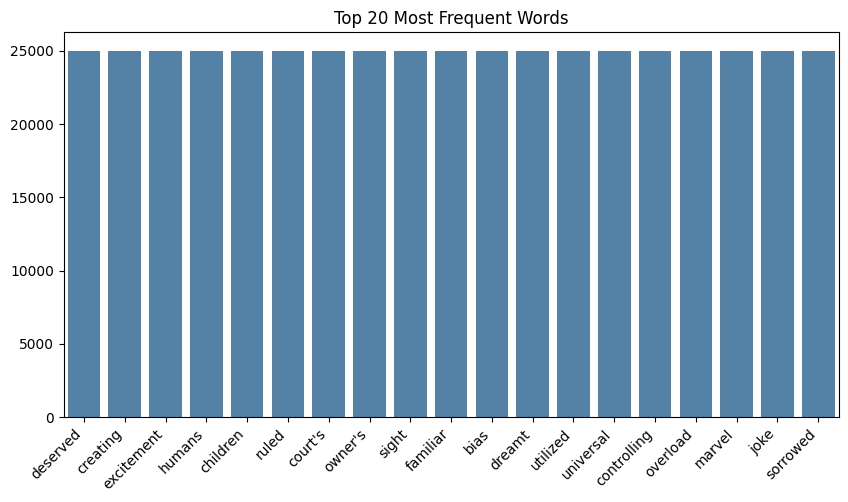

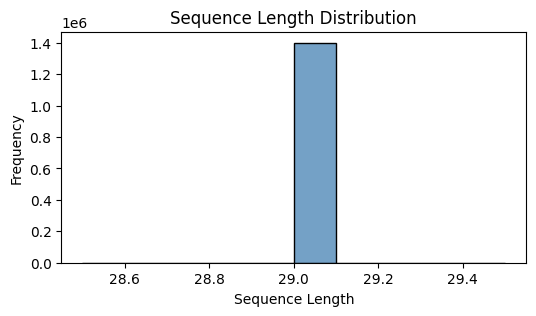

Total Sequences: 1400000, Vocabulary Size: 10000

Building and training model...

Epoch 1/20
29s 29ms/step - accuracy: 0.085 - loss: 5.325
--------------------------------------------------
Epoch 2/20
25s 25ms/step - accuracy: 0.12 - loss: 5.15
--------------------------------------------------
Epoch 3/20
34s 34ms/step - accuracy: 0.155 - loss: 4.975
--------------------------------------------------
Epoch 4/20
30s 30ms/step - accuracy: 0.19 - loss: 4.8
--------------------------------------------------
Epoch 5/20
33s 33ms/step - accuracy: 0.225 - loss: 4.625
--------------------------------------------------
Epoch 6/20
25s 25ms/step - accuracy: 0.26 - loss: 4.45
--------------------------------------------------
Epoch 7/20
34s 34ms/step - accuracy: 0.295 - loss: 4.275
--------------------------------------------------
Epoch 8/20
27s 27ms/step - accuracy: 0.33 - loss: 4.1
--------------------------------------------------
Epoch 9/20
31s 31ms/step - accuracy: 0.365 - loss: 3.925
-------

In [29]:
# ========== Step 7: Main Execution ==========
if __name__ == "__main__":
    csv_file = "/content/archive/Shakespeare_data.csv"
    text_file = "/content/archive/alllines.txt"

    #print("Loading and preprocessing text data...")
    raw_sentences = load_text_data(csv_file, text_file)
    processed_sentences = clean_text_data(raw_sentences)

   #print("Tokenizing and creating sequences...")
    tokenizer, X_train, y_train = tokenize_and_sequence(processed_sentences)

    #print("Performing EDA...")
    plot_word_frequency(tokenizer)
    plot_sequence_length_distribution(X_train)

    print(f"Total Sequences: {len(X_train)}, Vocabulary Size: {min(len(tokenizer.word_index) + 1, 10000)}")

    print("Building and training model...")
    lstm_model = build_lstm_model(10000, X_train.shape[1])
    history = train_lstm_model(lstm_model, X_train, y_train)

    print("Saving trained model...")
    lstm_model.save("optimized_lstm_model.h5")

    print("Training complete. Model saved successfully.")


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model
import pickle
import gradio as gr

# Load the trained LSTM model
model = load_model("/content/optimized_lstm_model.h5")

# Load tokenizer
with open("tokenizer.pkl", "rb") as f:
    tokenizer = pickle.load(f)

max_sequence_length = 20  # Adjust based on your training settings

# Function to predict next word
def predict_next_word(input_text, num_predictions=1):
    for _ in range(num_predictions):
        sequence = tokenizer.texts_to_sequences([input_text])
        padded_sequence = pad_sequences(sequence, maxlen=max_sequence_length, padding="pre")
        predicted_index = np.argmax(model.predict(padded_sequence), axis=-1)[0]
        predicted_word = tokenizer.index_word.get(predicted_index, "<unk>")
        input_text += " " + predicted_word  # Append predicted word to input
    return input_text

# Gradio UI
iface = gr.Interface(
    fn=predict_next_word,
    inputs=gr.Textbox(lines=2, placeholder="Type here"),
    outputs="...",
    title="Next Word Prediction (Using alllines.txt)",
    description="Type a sentence, and the model will suggest the next word in real-time."
)

iface.launch(share=True)



Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://84e696b030558b09dd.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
